In [1]:
import os
import numpy as np
import pandas as pd
import mne
from scipy.stats import kurtosis, skew
from scipy.signal import welch
import antropy as ant
import pandas as pd
import numpy as np

In [2]:
# Caminho para os dados
base_path = "/Users/analuiza/Documents/codes/templedata/tuh_eeg_epilepsy/v1.0.0/edf"

# Pré-Processamento dos dados

In [3]:
# Função para carregar os dados e criar o índice
def prepare_eeg_data(base_path):
    file_index = {}
    
    for category in ['epilepsy', 'no_epilepsy']:
        category_path = os.path.join(base_path, category)
        if not os.path.exists(category_path):
            print(f"Diretório não encontrado: {category_path}")
            continue

        for root, _, files in os.walk(category_path):
            for file in files:
                if file.lower().endswith('.edf'):
                    full_path = os.path.normpath(os.path.join(root, file))
                    file_index[full_path] = {
                        'file_path': full_path,
                        'category': category
                    }
    
    return file_index

In [6]:
# Função para calcular a entropia de Shannon manualmente
def shannon_entropy(data):
    _, counts = np.unique(data, return_counts=True)
    probs = counts / len(data)
    return -np.sum(probs * np.log2(probs))

# Função para processar um arquivo específico usando o caminho completo
def process_by_path(file_index, target_path):
    target_path = os.path.normpath(target_path)
    
    if target_path not in file_index:
        print(f"Arquivo não encontrado no índice: {target_path}")
        return None
    
    try:
        raw = mne.io.read_raw_edf(target_path, preload=False)
        print(f"\n{'-'*60}")
        print(f"Arquivo processado: {target_path}")
        print(f"Categoria: {file_index[target_path]['category']}")
        print(f"Número de canais: {len(raw.ch_names)}")
        print(f"Frequência de amostragem: {raw.info['sfreq']} Hz")
        return raw
    except Exception as e:
        print(f"Erro ao carregar {target_path}: {str(e)}")
        return None

# Função para processar todos os arquivos de uma vez
def process_all_files(file_index, window_size, fs):
    all_features = []
    
    for file_path, file_info in file_index.items():
        print(f"\nProcessando arquivo: {file_path}")
        raw_data = process_by_path(file_index, file_path)

        # Caso o arquivo seja carregado com sucesso, extraímos as características
        if raw_data:
            data, _ = raw_data[:]
            n_samples = data.shape[1]
            n_channels = data.shape[0]

            for start in range(0, n_samples - window_size, window_size):
                segment = data[:, start:start + window_size]
                feature_dict = {
                    "file": file_path,
                    "category": file_info['category'],
                }

                # Estatísticas básicas
                feature_dict["mean"] = np.mean(segment)
                feature_dict["variance"] = np.var(segment)
                feature_dict["kurtosis"] = kurtosis(segment.flatten())
                feature_dict["skewness"] = skew(segment.flatten())

                # Densidade Espectral de Potência (PSD)
                freqs, psd = welch(segment, fs, nperseg=window_size)
                feature_dict["psd_mean"] = np.mean(psd)
                feature_dict["psd_variance"] = np.var(psd)

                # Medidas de entropia
                feature_dict["shannon_entropy"] = shannon_entropy(segment.flatten())  # Entropia de Shannon manual
                feature_dict["perm_entropy"] = ant.perm_entropy(segment.flatten(), normalize=True)

                all_features.append(feature_dict)
    
    # Criar um DataFrame com os dados extraídos
    df = pd.DataFrame(all_features)
    df.to_csv("eeg_features.csv", index=False)  # Salvar para evitar reprocessamento
    print(f"\nProcessamento completo. Dados salvos em 'eeg_features.csv'.")

In [7]:
# Criar índice de arquivos
file_index = prepare_eeg_data(base_path)

# Definir o tamanho da janela e a frequência de amostragem
window_size = 5 * 250  # 5 segundos
fs = 250  # Frequência de amostragem (ajustar conforme necessário)

# Processar todos os arquivos
process_all_files(file_index, window_size, fs)


Processando arquivo: /Users/analuiza/Documents/codes/templedata/tuh_eeg_epilepsy/v1.0.0/edf/epilepsy/03_tcp_ar_a/076/00007656/s010_2011_03_13/00007656_s010_t000.edf
Extracting EDF parameters from /Users/analuiza/Documents/codes/templedata/tuh_eeg_epilepsy/v1.0.0/edf/epilepsy/03_tcp_ar_a/076/00007656/s010_2011_03_13/00007656_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

------------------------------------------------------------
Arquivo processado: /Users/analuiza/Documents/codes/templedata/tuh_eeg_epilepsy/v1.0.0/edf/epilepsy/03_tcp_ar_a/076/00007656/s010_2011_03_13/00007656_s010_t000.edf
Categoria: epilepsy
Número de canais: 34
Frequência de amostragem: 256.0 Hz

Processando arquivo: /Users/analuiza/Documents/codes/templedata/tuh_eeg_epilepsy/v1.0.0/edf/epilepsy/03_tcp_ar_a/076/00007656/s010_2011_03_13/00007656_s010_t001.edf
Extracting EDF parameters from /Users/analuiza/Documents/codes/templedata/tuh_eeg_epilepsy/v1.0.0/edf/epi

# Modelo de árvore de decisão

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
# Carregar os dados processados
df = pd.read_csv("eeg_features.csv")

In [10]:
# Separar features (X) e rótulos (y)
X = df.drop(columns=["file", "category"])
y = df["category"].map({"epilepsy": 1, "no_epilepsy": 0})  # Converte labels para 0 e 1

In [11]:
# Dividir em treino (70%) e teste (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [12]:
# Criar e treinar o modelo inicial
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [13]:
# Fazer previsões no conjunto de teste
y_pred = clf.predict(X_test)

In [14]:
# Avaliação do modelo
print("Acurácia:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Acurácia: 0.9065886719915156
              precision    recall  f1-score   support

           0       0.82      0.81      0.81     15033
           1       0.94      0.94      0.94     45313

    accuracy                           0.91     60346
   macro avg       0.88      0.87      0.87     60346
weighted avg       0.91      0.91      0.91     60346



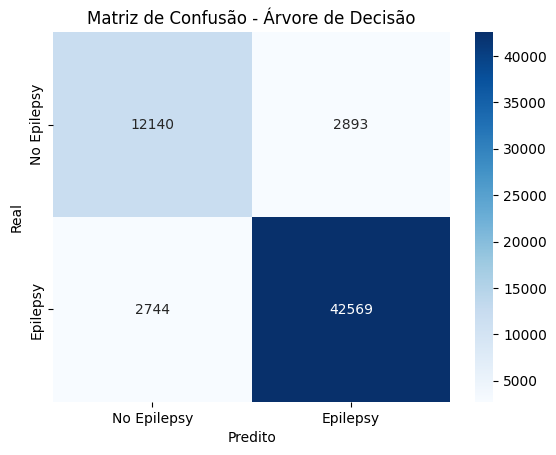

In [15]:
# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Epilepsy", "Epilepsy"], yticklabels=["No Epilepsy", "Epilepsy"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Árvore de Decisão")
plt.show()

### Otimização de Hiperparâmetros

In [18]:
# Definir espaço de busca para os hiperparâmetros
param_grid = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10],
    "criterion": ["gini", "entropy"]
}

In [19]:
# Grid Search com Validação Cruzada
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, None],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [20]:
# Melhor modelo encontrado
best_clf = grid_search.best_estimator_

In [21]:
# Previsões no conjunto de teste
y_pred_optimized = best_clf.predict(X_test)

In [22]:
# Avaliação do modelo otimizado
print("Acurácia após otimização:", accuracy_score(y_test, y_pred_optimized))
print(classification_report(y_test, y_pred_optimized))

Acurácia após otimização: 0.9096377556093196
              precision    recall  f1-score   support

           0       0.82      0.82      0.82     15033
           1       0.94      0.94      0.94     45313

    accuracy                           0.91     60346
   macro avg       0.88      0.88      0.88     60346
weighted avg       0.91      0.91      0.91     60346



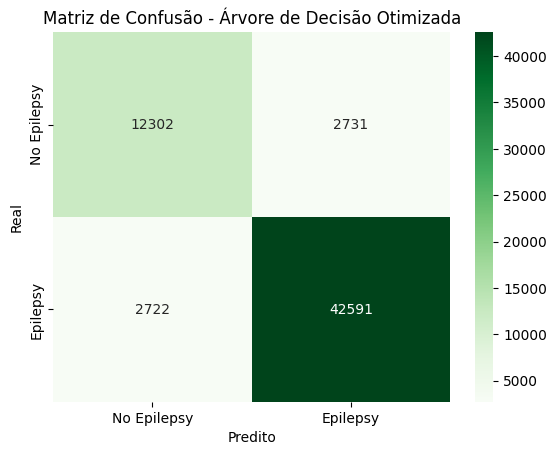

In [23]:
# Matriz de Confusão após otimização
conf_matrix_opt = confusion_matrix(y_test, y_pred_optimized)
sns.heatmap(conf_matrix_opt, annot=True, fmt="d", cmap="Greens", xticklabels=["No Epilepsy", "Epilepsy"], yticklabels=["No Epilepsy", "Epilepsy"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Árvore de Decisão Otimizada")
plt.show()